In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import math
import librosa
import librosa.display

path="/content/drive/MyDrive/PRNN_A1/"
path_test =path+"test/"
path_train =path+"train/"
train_music= path+"SA1.WAV"
train_phoneme = path+"SA1.PHN"

In [ ]:
data_path = '/content/drive/MyDrive/PRNN_A1/pneumoniamnist.npz'

data = np.load(data_path)
print('DATA FILES:', data.files)

x_train = data['train_images'].reshape(data['train_images'].shape[0],-1)
x_test = data['test_images'].reshape(data['test_images'].shape[0],-1)
x_val = data['val_images'].reshape(data['val_images'].shape[0],-1)
y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

FileNotFoundError: ignored

In [ ]:
print(np.shape(x_train))
print(np.shape(x_test))



(4708, 784)
(624, 784)


# DCGAN

In [ ]:
import tensorflow as tf


In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ck211wip
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ck211wip
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179812 sha256=82a33cb910607db0a6a11d0ba366c5209f9544cb395020feae99673529845de3
  Stored in directory: /tmp/pip-ephem-wheel-cache-qf13cmkd/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [ ]:
train_images = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
train_labels=y_train

train_images = (train_images - 127.5) / 127.5 

In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
train_dataset


<BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

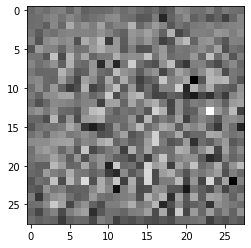

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00153333]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
generated_images_set=[]
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)
      generated_images_set.append(generated_images)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,epochs,seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(22, 22))

  for i in range(predictions.shape[0]):
      plt.subplot(10, 10, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  fig.savefig('image_at_epoch_{:04d}.jpg'.format(epoch))
  plt.show()
  print("")

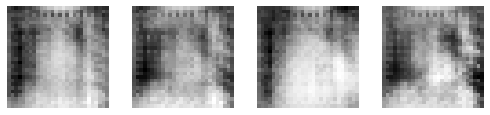

In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.jpg'.format(epoch_no))

In [ ]:
display_image(50)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:

gen=generated_images_set
gen=np.array(gen)
gen = gen.reshape(-1, 784)
np.shape(gen)
# gen=gen.numpy()


(48640, 784)

In [ ]:
mu1, sigma1 = x_train.mean(axis=0), np.cov(x_train, rowvar=False)
mu2, sigma2 = gen.mean(axis=0), np.cov(gen,  rowvar=False)
# samples.clear



from scipy import linalg

def calculate_fid(mu1, sigma1, mu2, sigma2):
    
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))

    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
       covmean = covmean.real

    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

fid = calculate_fid(mu1, sigma1, mu2, sigma2)
print(f'fid score: {fid}')

fid score: 18057484.62395662


# PCA and t-SNE

In [ ]:
from __future__ import print_function
import time
import numpy as np
import pandas as pd
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
X = x_train.reshape(x_train.shape[0],-1).astype('float32')
y=y_train

X.shape

(4708, 784)

In [ ]:
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (4708, 786)


In [ ]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

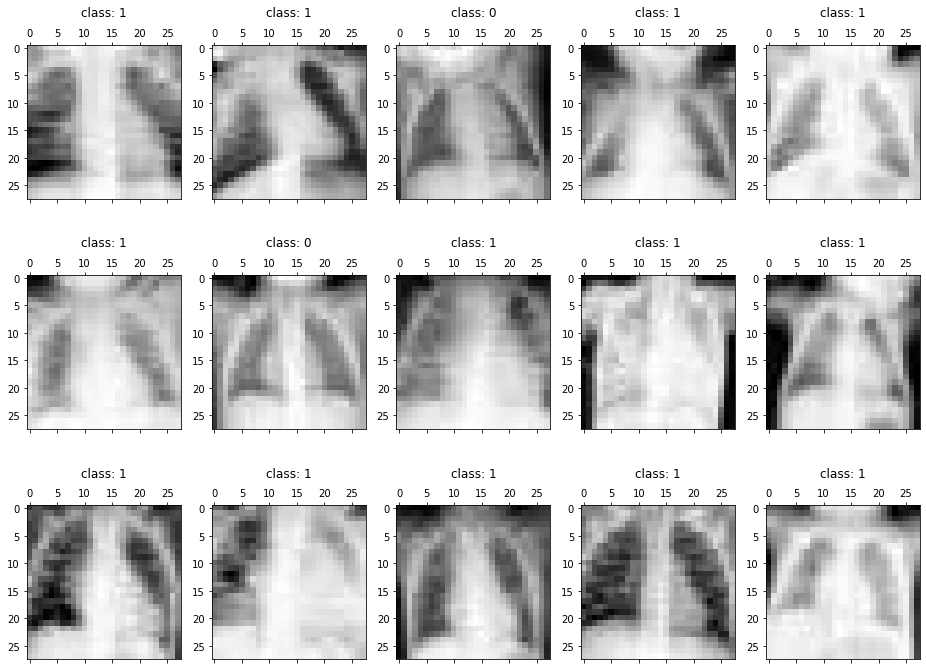

In [ ]:
plt.gray()
fig = plt.figure( figsize=(16,12) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="class: {}\n".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [ ]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.37871033 0.09647926 0.07009847]


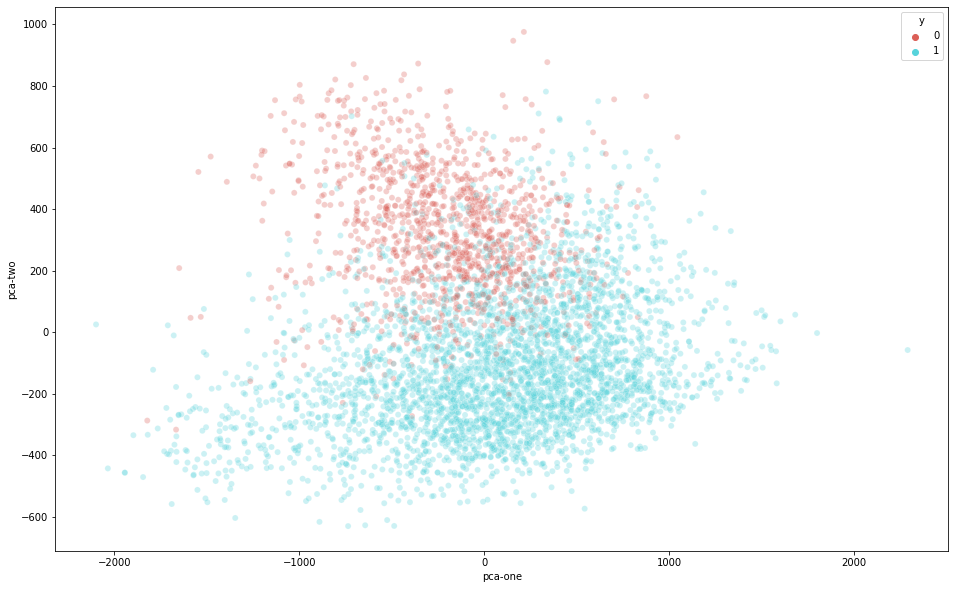

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

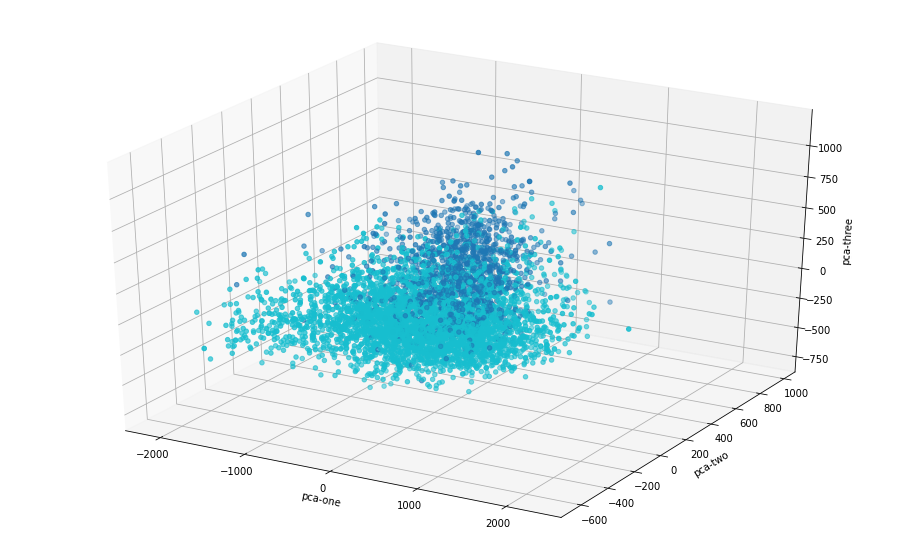

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
p=ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"],     
    cmap='tab10'
)
# ax.color_palette("hls", 2),
# fig.colorbar(p,ax=ax)
# ax.set_color("black","blue")
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## t-SNE

In [ ]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.37871036 0.09647914 0.07009836]


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4708 samples in 0.005s...
[t-SNE] Computed neighbors for 4708 samples in 1.382s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4708
[t-SNE] Computed conditional probabilities for sample 2000 / 4708
[t-SNE] Computed conditional probabilities for sample 3000 / 4708
[t-SNE] Computed conditional probabilities for sample 4000 / 4708
[t-SNE] Computed conditional probabilities for sample 4708 / 4708
[t-SNE] Mean sigma: 224.765872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.906143
[t-SNE] KL divergence after 300 iterations: 2.421983
t-SNE done! Time elapsed: 18.379817008972168 seconds


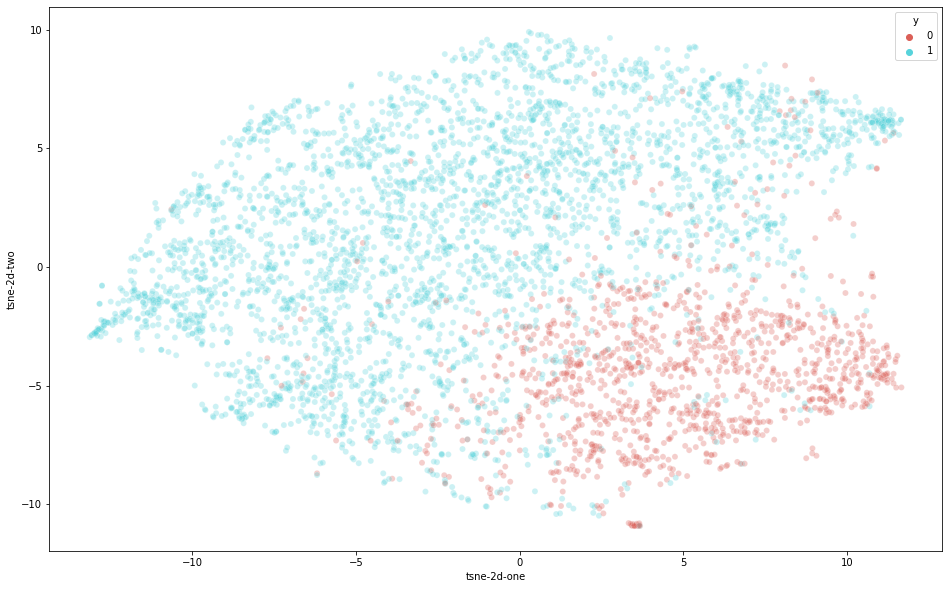

In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

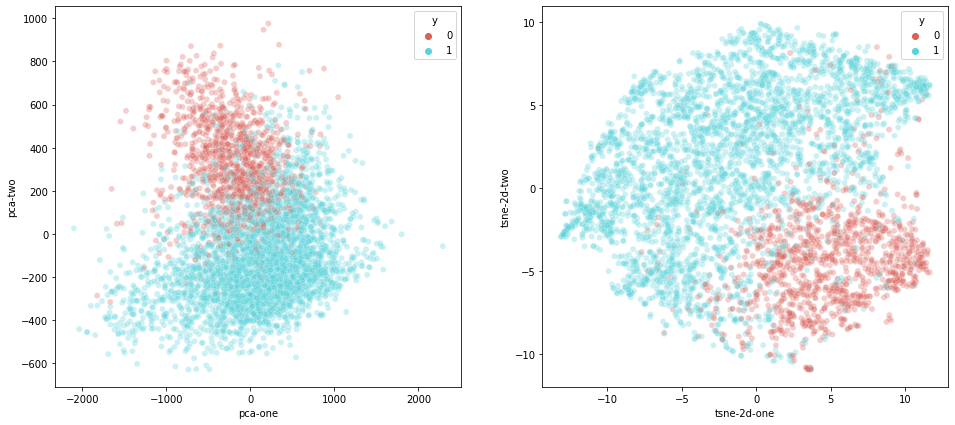

In [ ]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [ ]:
np.shape(tsne_results)
time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4708 samples in 0.005s...
[t-SNE] Computed neighbors for 4708 samples in 2.122s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4708
[t-SNE] Computed conditional probabilities for sample 2000 / 4708
[t-SNE] Computed conditional probabilities for sample 3000 / 4708
[t-SNE] Computed conditional probabilities for sample 4000 / 4708
[t-SNE] Computed conditional probabilities for sample 4708 / 4708
[t-SNE] Mean sigma: 224.765872
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.962830
[t-SNE] KL divergence after 300 iterations: 2.249659


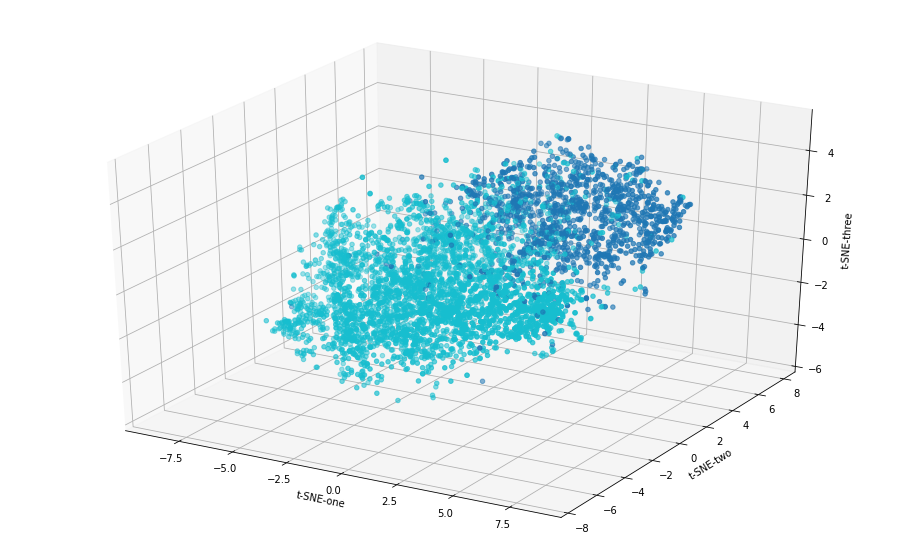

In [ ]:
#t-SNE 3d
df_subset['tsne-3d-one'] = tsne_results[:,0]
df_subset['tsne-3d-two'] = tsne_results[:,1]
df_subset['tsne-3d-three'] = tsne_results[:,2]
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     xs="tsne-3d-one", ys="tsne-3d-two",zs='tsne-3d-three',
#     hue="y",
#     palette=sns.color_palette("hls", 2),
#     data=df_subset,
#     legend="full",
#     alpha=0.3
# )
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
p=ax.scatter(
    xs=df_subset['tsne-3d-one'], 
    ys=df_subset['tsne-3d-two'], 
    zs=df_subset['tsne-3d-three'], 
    c=df.loc[rndperm,:]["y"],     
    cmap='tab10'
)
# ax.color_palette("hls", 2),
# fig.colorbar(p,ax=ax)
# ax.set_color("black","blue")
ax.set_xlabel('t-SNE-one')
ax.set_ylabel('t-SNE-two')
ax.set_zlabel('t-SNE-three')
plt.show()

In [ ]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.933219850063324


In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


t-SNE done! Time elapsed: 17.363475799560547 seconds


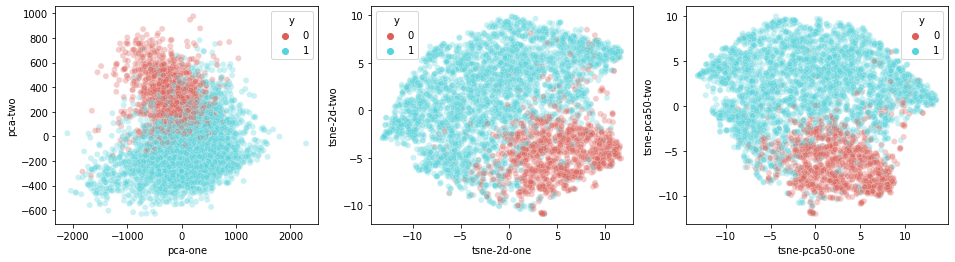

In [ ]:
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

# Reconstructions of data from initial k components of PCA deposition.

In [ ]:
X = x_train.reshape(x_train.shape[0],-1).astype('float32')
y=y_train

pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[feat_cols].values)


Size of the dataframe: (4708, 786)


In [ ]:
def pca_k_components(k,x):
  pca = PCA(n_components=k)
  pca_result = pca.fit_transform(x)
  new_x=np.dot(pca_result.T,x)
  plt.gray()
  mu1 = new_x.mean(axis=0)
  plt.gray()
  fig = plt.figure( figsize=(20,10) )
  
  plt.matshow(mu1.reshape((28,28)).astype(float))
  plt.title("Corresponding to frist {}-components\n".format(k))
  plt.savefig("Corresponding to frist {}-components.png".format(k))
  plt.show()
  return

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

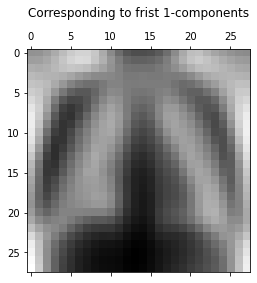

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

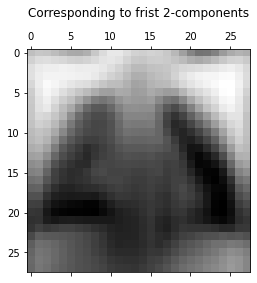

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

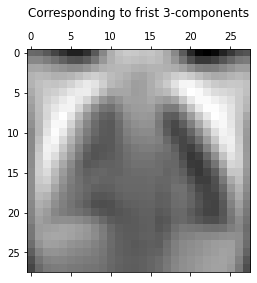

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

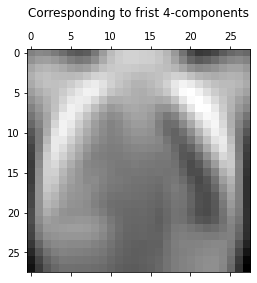

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

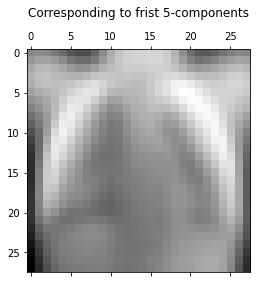

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

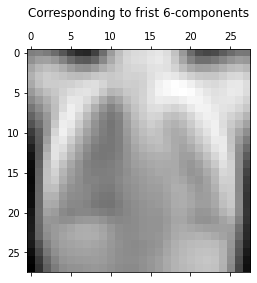

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

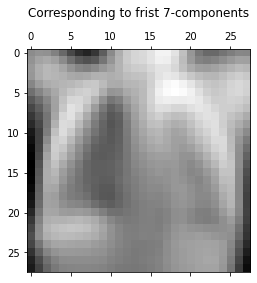

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

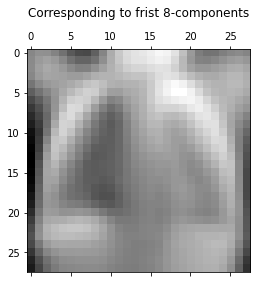

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

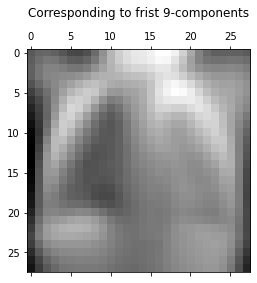

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

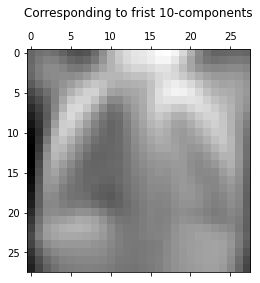

In [ ]:
for i in range(1,11):
  pca_k_components(i,df[feat_cols].values)

# Q6 

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


0.5753205128205128
Neighbors : 1 and accuracy : 0.5769230769230769
Neighbors : 2 and accuracy : 0.5753205128205128
Neighbors : 3 and accuracy : 0.5769230769230769
Neighbors : 4 and accuracy : 0.5865384615384616
Neighbors : 5 and accuracy : 0.5737179487179487
Neighbors : 6 and accuracy : 0.5801282051282052
Neighbors : 7 and accuracy : 0.5817307692307693
Neighbors : 8 and accuracy : 0.5849358974358975


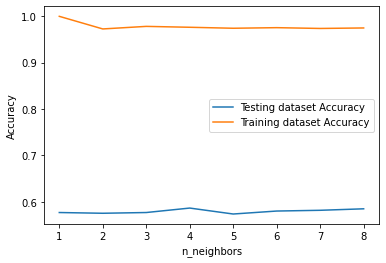

In [ ]:
#KNN on data labeled by K-means
X=x_train
Y=y_train
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

y=kmeans.labels_        #labels generated using kmean s=centroids
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X, y)
print(neigh.score(x_test, y_test))

neighbors = np.arange(1, 9)
y_axis=np.arange(0,1)
train_accuracy = np.empty(len(neighbors))
test_accuracy1 = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X, y)
    test_accuracy1[i] = knn.score(x_test, y_test)
    print("Neighbors : {} and accuracy : {}".format(k,test_accuracy1[i]))
# print(test_accuracy1)
# Generate plot
# fig = plt.figure( figsize=(5,10) )
plt.plot(neighbors, test_accuracy1, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

# plt.axis([0, 8, 0, 1.1])
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print(test_accuracy1)

0.8589743589743589
Neighbors : 1 and accuracy : 0.8237179487179487
Neighbors : 2 and accuracy : 0.8589743589743589
Neighbors : 3 and accuracy : 0.8285256410256411
Neighbors : 4 and accuracy : 0.8477564102564102
Neighbors : 5 and accuracy : 0.8221153846153846
Neighbors : 6 and accuracy : 0.8333333333333334
Neighbors : 7 and accuracy : 0.8285256410256411
Neighbors : 8 and accuracy : 0.8397435897435898


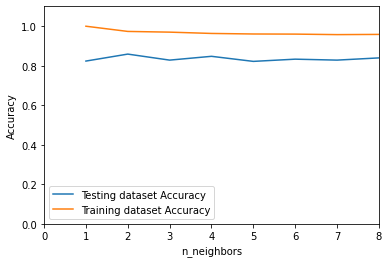

In [ ]:
#KNN on original labels
X=x_train
Y=y_train.reshape(-1)
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X, Y)
print(neigh.score(x_test, y_test))

neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy2 = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, Y)
     
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X, Y)
    test_accuracy2[i] = knn.score(x_test, y_test)
    print("Neighbors : {} and accuracy : {}".format(k,test_accuracy2[i]))

 
# Generate plot
# fig = plt.figure( figsize=(5,10) )
plt.plot(neighbors, test_accuracy2, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
# plt.yticks(np.arange(0, 1, 0.1))
# plt.axis('scaled')
plt.axis([0, 8, 0, 1.1])
plt.show()

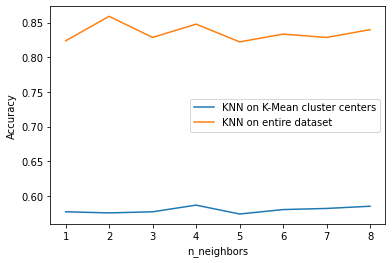

In [ ]:
# fig = plt.figure( figsize=(5,10) )
plt.plot(neighbors, test_accuracy1, label = 'KNN on K-Mean cluster centers')
plt.plot(neighbors, test_accuracy2, label = 'KNN on entire dataset')
 
plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
# plt.yticks(np.arange(0, 1, 0.1))
# plt.axis([0, 8, 0, 1])
plt.show()

# VAE



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 14, 14, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_18[0][0]']              
                                                                                                  
 flatten_9 (Flatten)            (None, 3136)         0           ['conv2d_19[0][0]']              
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_17 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_7 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_23 (Conv2D  (None, 28, 28, 1)        289 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x1=x_train.reshape(x_train.shape[0], 28, 28).astype('float32')
x2=x_test.reshape(x_test.shape[0], 28, 28).astype('float32')
# x1 = (x1 - 127.5) / 127.5 
# x2 = (x2 - 127.5) / 127.5 
data = np.concatenate([x1, x2], axis=0)
data = np.expand_dims(data, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data, epochs=30, batch_size=64)

Epoch 1/30
84/84 [==============================] - 9s 98ms/step - loss: 531.0164 - reconstruction_loss: 524.1634 - kl_loss: 0.1770
Epoch 2/30
84/84 [==============================] - 8s 98ms/step - loss: 517.8263 - reconstruction_loss: 517.2697 - kl_loss: 0.2938
Epoch 3/30
84/84 [==============================] - 8s 97ms/step - loss: 512.5440 - reconstruction_loss: 509.1396 - kl_loss: 2.2661
Epoch 4/30
84/84 [==============================] - 8s 98ms/step - loss: 510.0588 - reconstruction_loss: 507.5959 - kl_loss: 2.1097
Epoch 5/30
84/84 [==============================] - 8s 98ms/step - loss: 509.3204 - reconstruction_loss: 507.1452 - kl_loss: 1.9579
Epoch 6/30
84/84 [==============================] - 8s 98ms/step - loss: 508.5523 - reconstruction_loss: 507.0128 - kl_loss: 1.8946
Epoch 7/30
84/84 [==============================] - 8s 98ms/step - loss: 508.6138 - reconstruction_loss: 507.0098 - kl_loss: 1.8274
Epoch 8/30
84/84 [==============================] - 8s 98ms/step - loss: 508

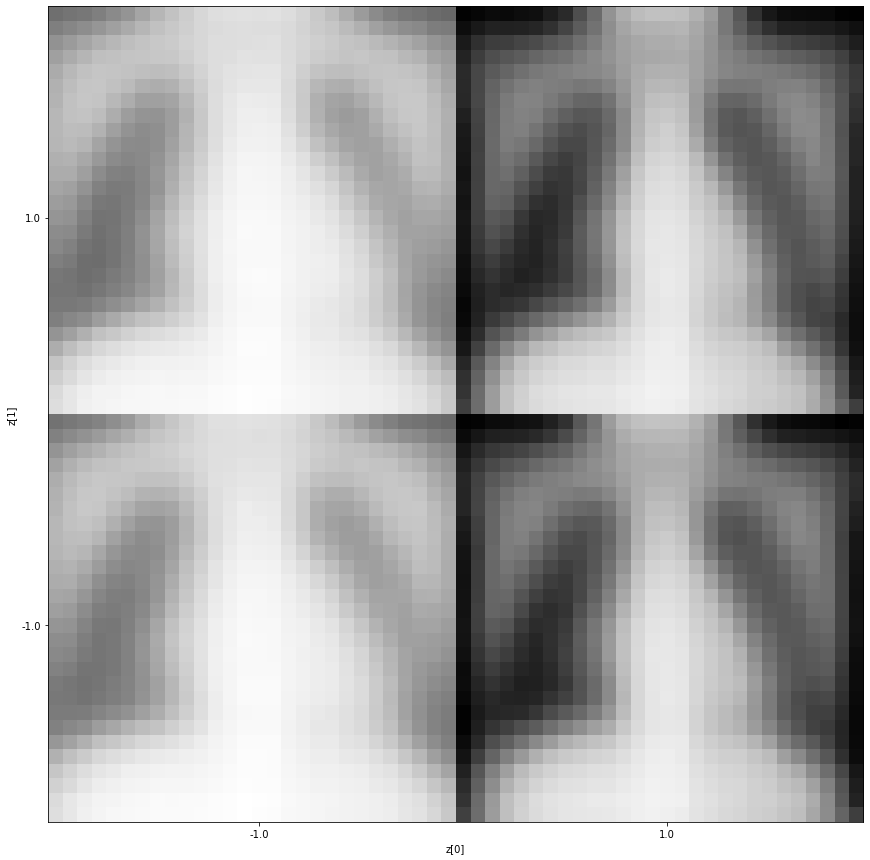

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=2, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

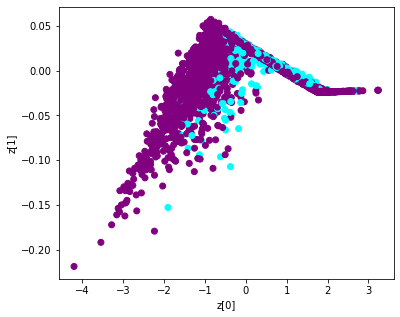

In [ ]:
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(6,5))
    
    colors = []
    for label in labels:
      if(label==0):
        colors.append('cyan')
      if(label==1):
        colors.append('purple')
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=colors, cmap='viridis')
    # for i in range(len(labels)):
    #   if(labels[i]==0):
    #     plt.scatter(z_mean[i, 0],z_mean[i, 1],color = 'hotpink')
    #   if(labels[i]==1):
    #     plt.scatter(z_mean[i, 0],z_mean[i, 1],color = '#88c999')
    # plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()



x_1= np.expand_dims(x1, -1).astype("float32") / 255

plot_label_clusters(vae, x_1, y_train)

In [ ]:
z_mean, _, _ = vae.encoder.predict(x_1)
len(z_mean)

4708

# Ensemble Classifier with Adaboost algorithm

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


from sklearn import svm

In [ ]:
clf = svm.SVC()
clf.fit(X, y)

SVC()

In [ ]:
X,Y=x_train,y_train.reshape(-1)

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X,Y)

print("AdaBoost(without base estimator) training accuracy : ",clf.score(X, Y)*100)
print("AdaBoost(without base estimator) testing accuracy : ",clf.score(x_test,y_test)*100)


AdaBoost(without base estimator) training accuracy :  98.91673746813933
AdaBoost(without base estimator) testing accuracy :  83.01282051282051


In [ ]:
clf_svm=svm.SVC(probability=True, kernel='rbf')
clf_svm.fit(X,Y)
print("SVM training accuracy : ",clf_svm.score(X, Y)*100)
print("SVM testing accuracy : ",clf_svm.score(x_test,y_test)*100)

clf_ada = AdaBoostClassifier(svm.SVC(probability=True, kernel='rbf'),n_estimators=10, random_state=0)
clf_ada.fit(X,Y)
print("SVM with AdaBoost training accuracy : ",clf_ada.score(X, Y)*100)
print("SVM with AdaBoost testing accuracy : ",clf_ada.score(x_test,y_test)*100)


SVM training accuracy :  98.06711979609176
SVM testing accuracy :  85.41666666666666


KeyboardInterrupt: ignored

In [ ]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

In [ ]:
X = x_train.reshape(x_train.shape[0], 28, 28).astype('float32')
X1 = x_test.reshape(x_tet.shape[0], 28, 28).astype('float32')
Y1 = y_test.reshape(-1)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X, Y, epochs=10,validation_data=(X1, Y1))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X1, Y1, verbose=2)

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

test_loss, test_acc = model.evaluate(X1, Y1, verbose=2)

clf_ada = AdaBoostClassifier(model,n_estimators=100, random_state=0)
clf_ada.fit(X,Y)
print("CNN with AdaBoost training accuracy : ",clf_ada.score(X, Y)*100)
print("CNN with AdaBoost testing accuracy : ",clf_ada.score(x_test,y_test)*100)
